<a href="https://colab.research.google.com/github/bel-elena/CAS-ADS/blob/main/Beletsioti_Module6_ECG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Elena Beletsioti, CAS ADS, UniBe, Module 6

# Goal

The MIT-BIH Arrhythmia Dataset is a well-known dataset used in heartbeat classification, which involve analyzing electrocardiogram (ECG) signals to diagnose cardiac arrhythmias and other heart-related conditions.

The MIT-BIH Arrhythmia Dataset contains ECG signals collected from 47 subjects, with each recording lasting for around 30 minutes. The dataset contains a total of 109,446 heartbeats, with annotations for 5 different types of arrhythmias, as well as normal heartbeats. The dataset has been widely used for benchmarking different heartbeat classification algorithms, including deep neural networks.

This dataset has been used extensively in the development of deep neural network models for heartbeat classification. Goal of this notebook is to build  models using convolutional neural networks, to analyze the ECG signals and identify different types of heartbeats. 

We will use the MIT-BIH Arrhythmia Dataset for benchmarking different heartbeat classification because of its relatively large size and diversity of arrhythmia types we believe it is a good choice for developing and evaluating classification models. 

Dataset can be downloaded here: https://www.physionet.org/content/mitdb/1.0.0/

## 1. Import modules we may need

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.utils import resample

In [34]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix

import tensorflow as tf

!pip install tensorflow-addons==0.16.1
import tensorflow_addons as tfa

from tensorflow import keras
from tensorflow.keras.layers import Dense, Conv1D, MaxPool1D, Flatten, Dropout, InputLayer, LSTM, GRU, BatchNormalization, Bidirectional, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.optimizers import SGD, RMSprop
from tensorflow.keras.utils import to_categorical

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 14.4 MB/s eta 0:00:00


/usr/local/lib/python3.9/dist-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.6.0 and strictly below 2.9.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.11.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


## 1.2 Load Datasets

In [3]:
# Load Google drive
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

# Define folder name where to get data from

folder_prefix = "/gdrive/MyDrive/Module6/"

Mounted at /gdrive
/gdrive


In [4]:
# Import Physionet's MIT-BIH Arrhythmia Test Dataset (MIT) from google drive 
import pandas as pd

mit_test  = pd.read_csv(folder_prefix + "mitbih_test.csv", header=None)
print("mit_test ")
mit_test.head()

mit_test 


,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
0,1.000000,0.758264,0.111570,0.000000,0.080579,0.078512,0.066116,0.049587,0.047521,0.035124,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.908425,0.783883,0.531136,0.362637,0.366300,0.344322,0.333333,0.307692,0.296703,0.300366,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.730088,0.212389,0.000000,0.119469,0.101770,0.101770,0.110619,0.123894,0.115044,0.132743,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.000000,0.910417,0.681250,0.472917,0.229167,0.068750,0.000000,0.004167,0.014583,0.054167,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.570470,0.399329,0.238255,0.147651,0.000000,0.003356,0.040268,0.080537,0.070470,0.090604,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
# Import Physionet's MIT-BIH Arrhythmia Train Dataset (MIT) from google drive 
import pandas as pd

mit_train  = pd.read_csv(folder_prefix + "mitbih_train.csv", header=None)
print("mit_train")
mit_train.head()

mit_train


,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
0,0.977941,0.926471,0.681373,0.245098,0.154412,0.191176,0.151961,0.085784,0.058824,0.049020,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.960114,0.863248,0.461538,0.196581,0.094017,0.125356,0.099715,0.088319,0.074074,0.082621,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.000000,0.659459,0.186486,0.070270,0.070270,0.059459,0.056757,0.043243,0.054054,0.045946,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.925414,0.665746,0.541436,0.276243,0.196133,0.077348,0.071823,0.060773,0.066298,0.058011,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.967136,1.000000,0.830986,0.586854,0.356808,0.248826,0.145540,0.089202,0.117371,0.150235,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## 1.3 Data Cleaning

In [6]:
# Rename column 187 to 'Class' in all four datasets, as its target variable for later
mit_test.rename(columns={187:"Class"}, inplace=True)
mit_train.rename(columns={187:"Class"}, inplace=True)

In [7]:
# Printthe class distribution for each dataset
print ("MIT Train classes: /n", mit_train["Class"].value_counts())
print ("/nMIT Test classes: /n", mit_test["Class"].value_counts())

MIT Train classes: /n 0.0    72471
4.0     6431
2.0     5788
1.0     2223
3.0      641
Name: Class, dtype: int64
/nMIT Test classes: /n 0.0    18118
4.0     1608
2.0     1448
1.0      556
3.0      162
Name: Class, dtype: int64


We understand from the output the number of occurrences of each class label in the "Class" column for each dataset. This information is useful to understand the distribution of classes.



*   **Normal Beat** - This refers to a normal, healthy heartbeat that occurs at the regular rate and rhythm.
*   **Artial Premature** - this label refers to an abnormal heartbeat that originates in the atria (the upper chambers of the heart) and occurs earlier than expected.
*   **Premature ventricular contraction** - this label refers to an abnormal heartbeat that originates in the ventricles (the lower chambers of the heart) and occurs earlier than expected.
*   **Fusion of ventricular and normal** - this label refers to an abnormal heartbeat that results from the fusion of a normal heartbeat with a premature ventricular contraction. 
*   **Unclassifiable Beat**' This refers to a heartbeat that cannot be classified into any of the other categories due to its unusual or atypical features.



In [8]:
# Setting Dictionary to define the type of Heartbeat for both datasets
MIT_Outcome  = {0. : 'Normal Beat',
               1. : 'Artial premature',
               2. : 'Premature ventricular contraction',
               3. : 'Fusion of ventricular and normal beat',
               4. : 'Unclassifiable Beat'}

By identifying and classifying these different types of heartbeats, the MIT-BIH Arrhythmia Database set can be used to develop and evaluate algorithms for automatic detection and diagnosis of arrhythmias, which can help improve the diagnosis and treatment of heart disease.

## 2. Explore the Data

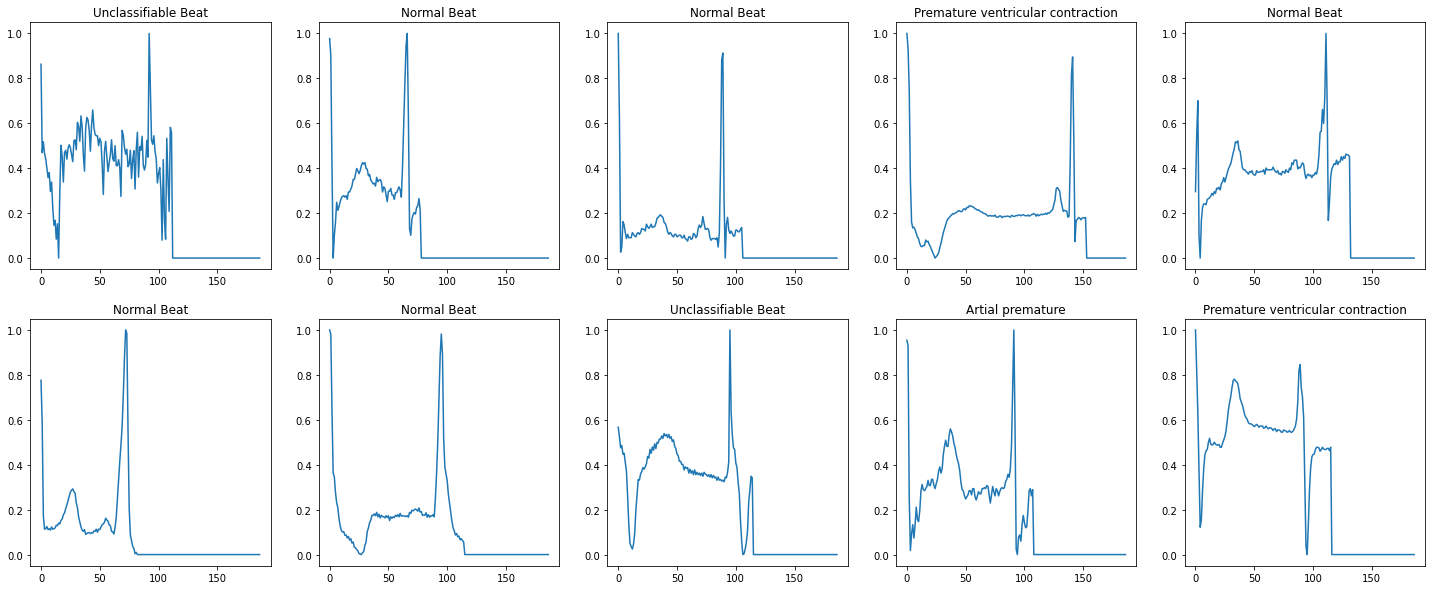

In [12]:
# Plotting 10 random samples from the MIT training dataset with their classification
plt.figure(figsize=(25,10))
np_count = np.linspace(0,186,187)
np_time = np.tile(np_count,(10,1))
rnd = np.random.randint(0,mit_train.shape[0],size=(10,))


for i in range(np_time.shape[0]):
    ax = plt.subplot(2,5,i+1)
    ax.plot(mit_train.iloc[rnd[i],np_time[i,:]])
    ax.set_title(MIT_Outcome[mit_train.loc[rnd[i],'Class']])

plt.show()

## 3. Deep Leaning Model for MIT-BIH Arrhythmia Dataset

### 3.1. Simple Neural Network with dense layers

We will build a neural network. The model is a fully NN that consists of three layers of densely connected neurons, followed by a softmax activation function on the output layer.

#### 3.1.1 Prepare data

In [13]:
# Prepare dataset 
X_train = mit_train.values[:, :-1]
y_train = mit_train.values[:, -1].astype(int)

X_test  = mit_test.values[:, :-1]
y_test  = mit_test.values[:, -1].astype(int)

# Print to display the dimensions of the feature arrays
print(X_train.shape)
print(X_test.shape)

(87554, 187)
(21892, 187)


In [14]:
from tensorflow.keras import utils # Function used to convert integer-encoded categorical data into one-hot encoded format

# Convert the integer-encoded labels to one-hot encoded format
y_train = utils.to_categorical(y_train)
y_test  = utils.to_categorical(y_test)

print(y_train.shape)
print(y_test.shape)

(87554, 5)
(21892, 5)


#### 3.1.2 Build the model

In [15]:
# Function to build Neural Network of three layers
from tensorflow.keras import models, layers

num_classes= 5 # number of neurons equal to num_classes for output

model = models.Sequential() # sequential model object, which is a linear stack of layers that can be added one by one

model.add(layers.InputLayer(input_shape=(187,))) # input layer with 187 neurons, which is the length of the ECG signal
model.add(layers.Dense(128, activation="relu")) # adding dense layer to the model with 128 neurons and a ReLU activation function
model.add(layers.Dense(32,  activation="relu")) # adding another dense layer to the model with 32 neurons and a ReLU activation function
model.add(layers.Dense(num_classes, activation="softmax")) # output layer with softmax activation function, which outputs a probability distribution over the classes, which can be used to make predictions

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               24064     
                                                                 
 dense_1 (Dense)             (None, 32)                4128      
                                                                 
 dense_2 (Dense)             (None, 5)                 165       
                                                                 
Total params: 28,357
Trainable params: 28,357
Non-trainable params: 0
_________________________________________________________________


In [16]:
# Compile Model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

The categorical cross-entropy loss function is commonly used for multi-class classification problems, where the goal is to predict a categorical label from a set of possible classes. The Adam optimizer is a popular choice for optimizing neural networks.

In [17]:
batch_size = 100
num_epochs = 20

# Train Model
hist = model.fit(X_train, y_train, epochs=num_epochs, batch_size=batch_size, validation_data=(X_test, y_test))

Epoch 1/20
876/876 [==============================] - 4s 4ms/step - loss: 0.3279 - accuracy: 0.9104 - val_loss: 0.1980 - val_accuracy: 0.9447
Epoch 2/20
876/876 [==============================] - 4s 5ms/step - loss: 0.1697 - accuracy: 0.9534 - val_loss: 0.1574 - val_accuracy: 0.9575
Epoch 3/20
876/876 [==============================] - 4s 4ms/step - loss: 0.1411 - accuracy: 0.9614 - val_loss: 0.1365 - val_accuracy: 0.9635
Epoch 4/20
876/876 [==============================] - 3s 3ms/step - loss: 0.1244 - accuracy: 0.9654 - val_loss: 0.1301 - val_accuracy: 0.9646
Epoch 5/20
876/876 [==============================] - 3s 3ms/step - loss: 0.1134 - accuracy: 0.9690 - val_loss: 0.1183 - val_accuracy: 0.9671
Epoch 6/20
876/876 [==============================] - 4s 4ms/step - loss: 0.1043 - accuracy: 0.9709 - val_loss: 0.1131 - val_accuracy: 0.9689
Epoch 7/20
876/876 [==============================] - 5s 5ms/step - loss: 0.0980 - accuracy: 0.9726 - val_loss: 0.1097 - val_accuracy: 0.9701
Epoch 

The output shows that the model starts with a training loss of 0.0787 and a training accuracy of 0.9776 for the first epoch, and continues to improve in each subsequent epoch. After 20 epochs, the model achieves a training loss of 0.0454 and a training accuracy of 0.9857. The validation loss and accuracy  displayed for each epoch, show that the model generalizes well to unseen data.

In [18]:
labels = ["Normal Beat",
          "Artial Premature",
          "Premature ventricular contraction",
          "Fusion of ventricular and normal",
          "Fusion of paced and normal"]

In [19]:
# Test Model
predY = model.predict(X_test)
y_pred = np.argmax(predY,axis=1)
y_actual = np.argmax(y_test,axis=1)
cm = confusion_matrix(y_actual, y_pred) # confusion matrix summarizes the number of true positives, false positives, true negatives, and false negatives for each class
print(cm)

685/685 [==============================] - 1s 1ms/step
[[17997    56    44    12     9]
 [  155   390    10     0     1]
 [   65     3  1347    28     5]
 [   31     0    13   118     0]
 [   50     0    17     0  1541]]


#### 3.1.3 Evaluation of the model

In [20]:
print(classification_report(y_actual, y_pred, target_names=labels))

                                   precision    recall  f1-score   support

                      Normal Beat       0.98      0.99      0.99     18118
                 Artial Premature       0.87      0.70      0.78       556
Premature ventricular contraction       0.94      0.93      0.94      1448
 Fusion of ventricular and normal       0.75      0.73      0.74       162
       Fusion of paced and normal       0.99      0.96      0.97      1608

                         accuracy                           0.98     21892
                        macro avg       0.91      0.86      0.88     21892
                     weighted avg       0.98      0.98      0.98     21892



From the output, we can see that the model has an overall accuracy of 0.98, meaning that it correctly classified 98% of the total observations in the test set.

Looking at the precision, recall, and F1-score for each class, we can see that the model performs very well for the "Normal" class, with a precision, recall, and F1-score of 0.99. This is expected as the "Normal" class is the most represented in the dataset with 18,118 observations.

For the other classes, we can see that the performance varies. For instance, the model performs relatively well for the "Fusion of paced and normal" class with a precision, recall, and F1-score of 0.98. On the other hand, the model performs less well for the "Fusion of ventricular and normal" class, with a precision, recall, and F1-score of 0.85, 0.67, and 0.75, respectively.

The macro and weighted average F1-score are 0.89 and 0.98, respectively. The macro-average calculates the F1-score for each class and takes the average, while the weighted average takes the average weighted by the number of observations for each class.

Overall, these results indicate that the model performs well in classifying most of the classes in the dataset, but there may be room for improvement in some of the less represented classes.

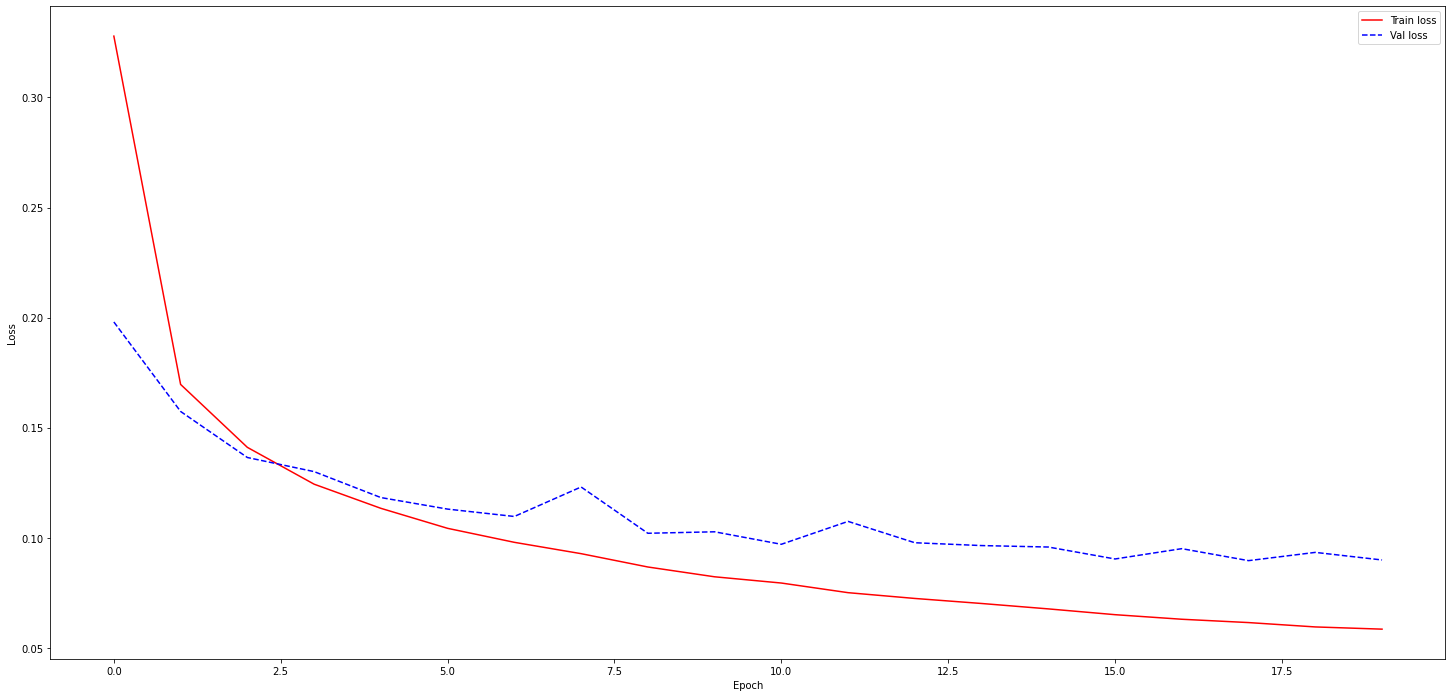

In [46]:
# Plotting the training and validatoin results
plt.figure(figsize=(25,12))
plt.plot(hist.epoch, hist.history['loss'],
           color='r', label='Train loss')
plt.plot(hist.epoch, hist.history['val_loss'],
           color='b', label='Val loss' , linestyle="--")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

### 3.2 Complex CNN with several convolutional layers followed by dense layers

Peviously, we created a simple model which relies solely on dense layers to learn patterns in the data.

Now, we attempt to build a more complex model. This model, uses a 1D convolutional layer with a kernel size of 7 and a stride of 1, followed by batch normalization, ReLU activation, and max pooling layers. This pattern is repeated several times with increasing number of filters in the convolutional layers. Then, the output is flattened and fed to several dense layers with dropout regularization, and finally, an output layer with softmax activation function.

#### 3.2.1 Prepare the data

In [21]:
# Split 20% of the training set for validation
train_mit, valid_mit, out_train_mit, out_valid_mit = train_test_split(mit_train.iloc[:,:187], mit_train.iloc[:,-1], test_size=0.20, random_state=42)

# Remove the targets from the test set
test_mit, out_test_mit = mit_test.iloc[:,:187], mit_test.iloc[:,-1]

# Normalizing the training & test data 
train_mit = normalize(train_mit, axis=0, norm='max')
valid_mit = normalize(valid_mit, axis=0, norm='max')
test_mit = normalize(test_mit, axis=0, norm='max')

In [22]:
# Reshaping the dataframe into a 3-D Numpy array (batch, Time Period, Value)
x_train_mit = train_mit.reshape(len(train_mit),train_mit.shape[1],1)
x_valid_mit = valid_mit.reshape(len(valid_mit),valid_mit.shape[1],1)
x_test_mit = test_mit.reshape(len(test_mit),test_mit.shape[1],1)

# Converting the output into a categorical array for each class
y_train_mit = to_categorical(out_train_mit)
y_valid_mit = to_categorical(out_valid_mit)
y_test_mit = to_categorical(out_test_mit)

In [26]:
print("Traing dataset size: ", x_train_mit.shape , " -- Y size: ", y_train_mit.shape)
print("Validation dataset size: ", x_valid_mit.shape , " -- Y size: ", y_valid_mit.shape)
print("Test dataset size: ", x_test_mit.shape , " -- Y size: ", y_test_mit.shape)

Traing dataset size:  (70043, 187, 1)  -- Y size:  (70043, 5)
Validation dataset size:  (17511, 187, 1)  -- Y size:  (17511, 5)
Test dataset size:  (21892, 187, 1)  -- Y size:  (21892, 5)


As class imbalance is a problem we encountered before, as some classes have significantly fewer samples than other classes, and subsequently this led to poor performance for those classes during training and testing, now we create Class weights to address this problem by giving more weight to the minority classes during training, thereby ensuring that the model learns to recognize all classes with equal importance.

In [27]:
# Calculating the class weights dictionary to feed into the model
normalmit, superpre, prevent, fusion, unclass = np.bincount(mit_train.loc[:,'Class']) # Calculate the number of samples in each class
total_rec = len(mit_train)
normmit_weight = (1/normalmit) * (total_rec/5) # Calculate the weight for each class 
superpre_weight = (1/superpre) * (total_rec/5)
prevent_weight = (1/prevent) * (total_rec/5)
fusion_weight =  (1/fusion) * (total_rec/5)
unclass_weight = (1/unclass) * (total_rec/5)
class_weight_mit = {0: normmit_weight, 1: superpre_weight, 2: prevent_weight,
               3: fusion_weight, 4: unclass_weight} # class weights are stored in a dictionary class_weight_mit with the class label as the key and its weight as the value

#### 3.2.2 Build the model

In [28]:
# Clear any existing models or layers from the backend, freeing up memory and resources
tf.keras.backend.clear_session() 

# Function to build Convolutional 1D Networks
def build_conv1d_model_mit (input_shape=(x_train_mit.shape[1],1)):
    model = keras.models.Sequential()
    
    model.add(Conv1D(32,7, padding='same', input_shape=input_shape)) # Conv1D = layer with 32 filters, kernel size of 7, and same padding
    model.add(tf.keras.layers.ReLU()) # ReLU activation function
    model.add(MaxPool1D(5,padding='same')) # MaxPool1D layer with pool size of 5 and same padding. This layer reduces the dimensionality of the output of the previous layer

    # Repeated with 64, 128, 256, and 512 filters in subsequent Conv1D layers
    model.add(Conv1D(64,7, padding='same'))
    model.add(BatchNormalization()) # BatchNormalization layer to normalize the activations of the previous layer
    model.add(tf.keras.layers.ReLU())
    model.add(MaxPool1D(5,padding='same'))

    model.add(Conv1D(128,7, padding='same'))
    model.add(BatchNormalization())
    model.add(tf.keras.layers.ReLU())
    model.add(MaxPool1D(5,padding='same'))

    model.add(Conv1D(256,7, padding='same'))
    model.add(BatchNormalization())
    model.add(tf.keras.layers.ReLU())
    model.add(MaxPool1D(5,padding='same'))

    model.add(Conv1D(512,7, padding='same'))
    model.add(BatchNormalization())
    model.add(tf.keras.layers.ReLU())
    model.add(MaxPool1D(5,padding='same'))

    # Flatten the output of the last convolutional layer to a one-dimensional array.
    model.add(Flatten())
    # Three fully connected Dense layers with 512, 256, and 128 neurons, each followed by a ReLU activation function 
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5)) # Dropout layer to prevent overfitting
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    #Two more fully connected Dense layers with 64 and 32 neurons, each followed by a ReLU activation function
    model.add(Dense(64, activation='relu'))
    model.add(Dense(32, activation='relu'))
    # Final Dense layer with 5 neurons (equal to the number of classes) and a softmax activation function to output class probabilities
    model.add(Dense(5, activation="softmax"))

    # Compile Model
    model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=[tfa.metrics.F1Score(5,"micro")])
    return model

 The model is complex with multiple convolutional and fully connected layers, and uses batch normalization, dropout, and ReLU activation to improve performance and reduce overfitting.

Note: We added the Dropout layer ater having the suspicion that the model might be overfitting. During training, dropout randomly sets a fraction of the input units to 0 at each update, which can help prevent the model from relying too much on any specific subset of inputs, and thus helps to generalize better to new unseen data.

We used Dropout layers after each Dense layer, with a rate of 0.5. This means that half of the units in the layer will be randomly set to 0 during each update, effectively dropping them out of the network for that particular forward pass.

The Dropout layer in this model helps to prevent overfitting by reducing the dependence of the model on any particular input unit and helps in creating a more generalized model.

In [35]:
model_conv1d_mit= build_conv1d_model_mit(input_shape=(x_train_mit.shape[1], x_train_mit.shape[2]))
model_conv1d_mit.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_5 (Conv1D)           (None, 187, 32)           256       
                                                                 
 re_lu_5 (ReLU)              (None, 187, 32)           0         
                                                                 
 max_pooling1d_5 (MaxPooling  (None, 38, 32)           0         
 1D)                                                             
                                                                 
 conv1d_6 (Conv1D)           (None, 38, 64)            14400     
                                                                 
 batch_normalization_4 (Batc  (None, 38, 64)           256       
 hNormalization)                                                 
                                                                 
 re_lu_6 (ReLU)              (None, 38, 64)           

In [133]:
#from tensorflow.keras.utils import plot_model

#tf.keras.utils.plot_model(model_conv1d_mit, show_shapes=True)

In [38]:
history_conv1d_mit = model_conv1d_mit.fit(x_train_mit, y_train_mit, epochs=10, batch_size=32, 
                             class_weight=class_weight_mit, validation_data=(x_valid_mit, y_valid_mit))

Epoch 1/10
2189/2189 [==============================] - 300s 137ms/step - loss: 0.2604 - f1_score: 0.9072 - val_loss: 0.3082 - val_f1_score: 0.9210
Epoch 2/10
2189/2189 [==============================] - 286s 131ms/step - loss: 0.2658 - f1_score: 0.8955 - val_loss: 0.3036 - val_f1_score: 0.9169
Epoch 3/10
2189/2189 [==============================] - 280s 128ms/step - loss: 0.2794 - f1_score: 0.8961 - val_loss: 0.3296 - val_f1_score: 0.9135
Epoch 4/10
2189/2189 [==============================] - 279s 128ms/step - loss: 0.2806 - f1_score: 0.8922 - val_loss: 0.4764 - val_f1_score: 0.8553
Epoch 5/10
2189/2189 [==============================] - 281s 128ms/step - loss: 0.2660 - f1_score: 0.8991 - val_loss: 0.2591 - val_f1_score: 0.9170
Epoch 6/10
2189/2189 [==============================] - 279s 127ms/step - loss: 0.2235 - f1_score: 0.9173 - val_loss: 0.2849 - val_f1_score: 0.9230
Epoch 7/10
2189/2189 [==============================] - 277s 127ms/step - loss: 0.2920 - f1_score: 0.8896 - val_

In [42]:
# Test model
model_conv1d_mit.evaluate(x_test_mit, y_test_mit) # evaluate method computes loss and accuracy of the model
conv1d_pred_mit_proba = model_conv1d_mit.predict (x_test_mit) #  predict class probabilities of input signals in test set
conv1d_pred_mit = np.argmax(conv1d_pred_mit_proba,axis=1) # give predicted class labels for each input signal in test set

685/685 [==============================] - 8s 12ms/step


#### 3.2.3 Evaluation of the model

In [43]:
print(classification_report(out_test_mit, conv1d_pred_mit, target_names=[MIT_Outcome[i] for i in MIT_Outcome]))

                                       precision    recall  f1-score   support

                          Normal Beat       0.98      0.86      0.92     18118
                     Artial premature       0.16      0.88      0.28       556
    Premature ventricular contraction       0.98      0.74      0.84      1448
Fusion of ventricular and normal beat       0.46      0.89      0.61       162
                  Unclassifiable Beat       0.99      0.95      0.96      1608

                             accuracy                           0.86     21892
                            macro avg       0.71      0.86      0.72     21892
                         weighted avg       0.95      0.86      0.90     21892



Looking at the results, we can see that the model performs very well on the 'Normal Beat' and 'Unclassifiable Beat' classes, with high precision, recall, and F1-scores. However, the model has a low precision for the 'Artial premature' and 'Fusion of ventricular and normal beat' classes, indicating that a large proportion of the positive predictions for these classes are false positives. On the other hand, the model has a low recall for the 'Premature ventricular contraction' class, indicating that a large proportion of the positive cases for this class are missed by the model.

Overall, the weighted average F1-score of 0.90 indicates that the model has a decent balance between precision and recall across all classes, although there is definitely room for improvement in the performance of the model for the 'Artial premature', 'Premature ventricular contraction', and 'Fusion of ventricular and normal beat' classes.

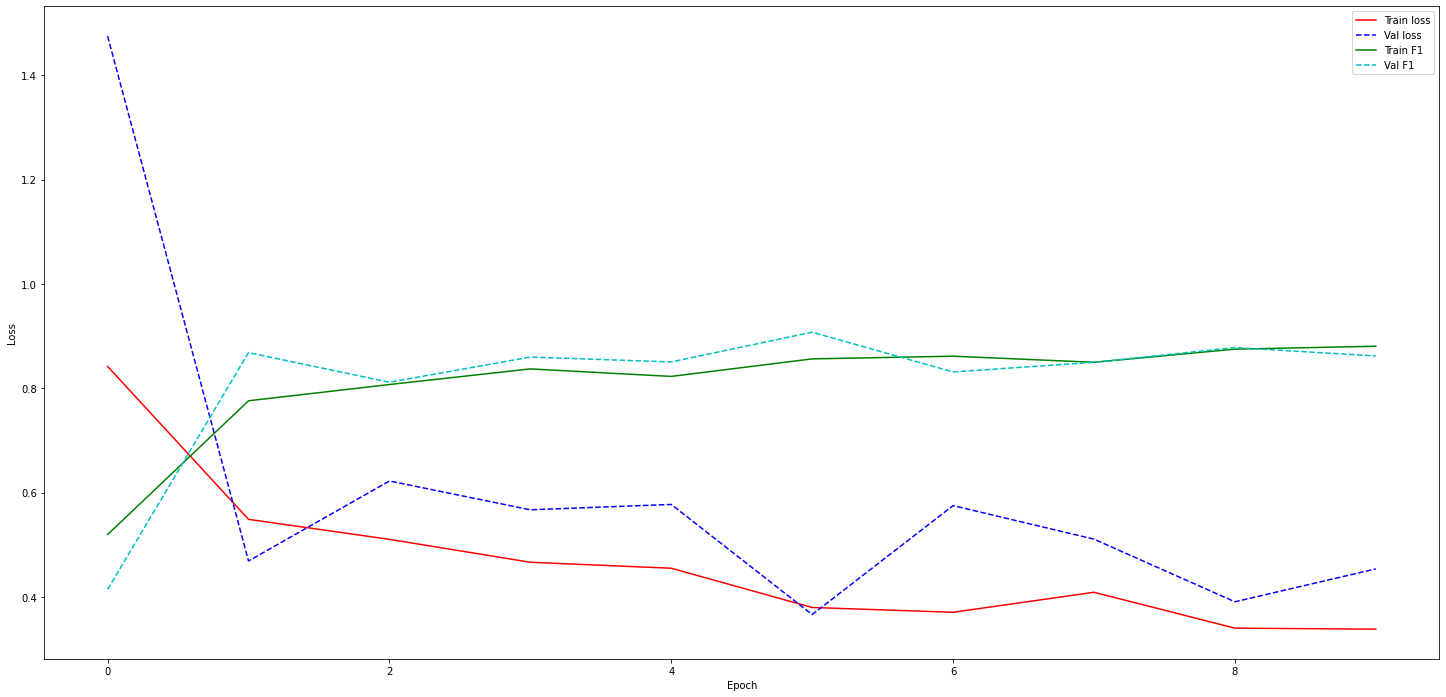

In [158]:
# Plotting the training and validatoin results
plt.figure(figsize=(25,12))
plt.plot(history_conv1d_mit.epoch, history_conv1d_mit.history['loss'],
           color='r', label='Train loss')
plt.plot(history_conv1d_mit.epoch, history_conv1d_mit.history['val_loss'],
           color='b', label='Val loss' , linestyle="--")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(history_conv1d_mit.epoch, history_conv1d_mit.history['f1_score'],
           color='g', label='Train F1')
plt.plot(history_conv1d_mit.epoch, history_conv1d_mit.history['val_f1_score'],
           color='c', label='Val F1' , linestyle="--")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()